In [93]:
%pip install itables tqdm

import math
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
from scipy.stats import entropy
from itertools import permutations


def safe_log2(x):
    return math.log2(x) if x > 0 else 0


def tuple_to_string(num_tuple):
    return ''.join(map(str, num_tuple))


def calculate_bulls_cows(source, target):
    if len(source) != len(target):
        raise ValueError("Input arrays must have the same length")

    bulls = sum(s == t for s, t in zip(source, target))
    common_digits = set(source) & set(target)
    cows = sum(min(source.count(digit), target.count(digit)) for digit in common_digits) - bulls

    return bulls, cows


def get_pattern_distribution_dict(candidates):
    pattern_distribution_dict = {}
    bulls_cows_dict = {}
    for i, source in tqdm(enumerate(candidates), total=len(candidates)):
        pattern_dist = {}
        for j, target in enumerate(candidates):
            if i < j:
                bulls_cows = calculate_bulls_cows(source, target)
                bulls_cows_dict[source, target] = bulls_cows
                bulls_cows_dict[target, source] = bulls_cows
            elif i == j:
                bulls_cows_dict[source, source] = (len(source), 0)
            
            guess_result = bulls_cows_dict[source, target]
            if tuple_to_string(guess_result) in pattern_dist:
                pattern_dist[tuple_to_string(guess_result)] += 1
            else:
                pattern_dist[tuple_to_string(guess_result)] = 1

        pattern_distribution_dict[source] = pattern_dist

    return pattern_distribution_dict


def calc_entropy_dict(candidates):
    entropy_dict = {}
    pattern_distribution_dict = get_pattern_distribution_dict(candidates)

    for candidate in pattern_distribution_dict:
        pattern_dist = pattern_distribution_dict[candidate]
        entropy_dict[candidate] = entropy(list(pattern_dist.values()), base=2)

    return sorted(entropy_dict.items(), reverse=True)



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [108]:
class BullsNCows:
    def __init__(self, digits=4, random=True):
        permute = permutations([i for i in range(10)], digits)
        self.originals = [tuple_to_string(p) for p in list(permute)]
        self.digits = digits
        self.random = random


    def reset(self):
        self.attempts = 0
        self.secret = random.choice(self.originals)
        self.candidates = self.originals
        self.summary = [{
            "candidate_count": len(self.candidates),
            "candidate_entropy": safe_log2(len(self.candidates)),
        }]


    def next(self):
        if not self.random and self.attempts > 0:
            entropy_dict = calc_entropy_dict(self.candidates)
            print(entropy_dict)
            guess, guess_entropy = entropy_dict[0]
        else:
            guess = random.choice(self.candidates)
            guess_entropy = np.NaN

        self.attempts += 1
        guess_result = calculate_bulls_cows(self.secret, guess)
        self.candidates = [c for c in self.candidates if calculate_bulls_cows(guess, c) == guess_result]
        self.summary.append({
            "guess": guess,
            "guess_result": guess_result,
            "guess_actual_entropy": self.summary[-1]['candidate_entropy']-safe_log2(len(self.candidates)),
            "guess_expect_entropy": guess_entropy,
            "candidate_count": len(self.candidates),
            "candidate_entropy": safe_log2(len(self.candidates)),
        })

        return self


    def play(self):
        self.reset()
        while len(self.candidates) > 1:
            self.next()

        return self.attempts, pd.DataFrame.from_dict(self.summary)

In [114]:
_, df = BullsNCows(digits=3, random=True).play(); df

,candidate_count,candidate_entropy,guess,guess_result,guess_actual_entropy,guess_expect_entropy
0,720,9.491853,NaN,NaN,NaN,NaN
1,210,7.714246,728,"(0, 0)",1.777608,NaN
2,24,4.584963,561,"(1, 1)",3.129283,NaN
3,9,3.169925,951,"(0, 1)",1.415037,NaN
4,2,1.000000,536,"(2, 0)",2.169925,NaN
5,1,0.000000,506,"(2, 0)",1.000000,NaN


  5%|▍         | 46/1000 [00:00<00:03, 250.20it/s]

100%|██████████| 5/5 [01:18<00:00, 15.75s/it]


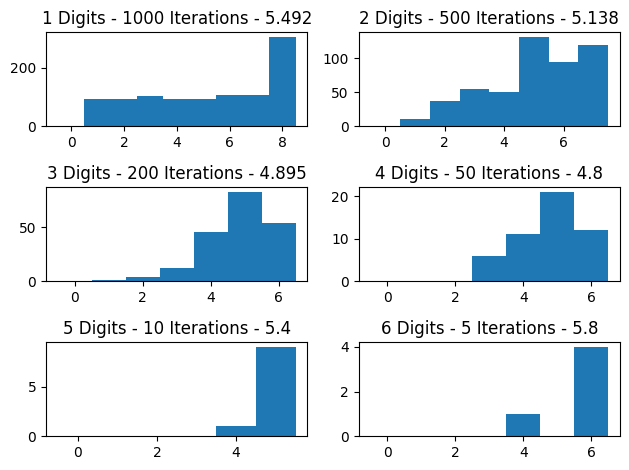

In [170]:
import matplotlib.pyplot as plt

MAX_DIGITS=6
iter_dict = {
    1: 1000,
    2: 500,
    3: 200,
    4: 50,
    5: 10,
    6: 5,
}

for digits in range(1, MAX_DIGITS+1):
    game = BullsNCows(digits=digits, random=True)
    scores = [game.play()[0] for _ in tqdm(range(iter_dict[digits]))]

    plt.subplot((MAX_DIGITS+1)//2, 2, digits)
    plt.title(f'{digits} Digits - {iter_dict[digits]} Iterations - {sum(scores) / len(scores)}')
    plt.hist(scores, bins=np.arange(0, max(scores)+1), align='left')

plt.tight_layout()
plt.show()